In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.preprocessing import MinMaxScaler
from torch import nn
import seaborn as sns

In [2]:
dfi = pd.read_csv('./Data/Weather/san-francisco.csv')
dfi

DATE  WND_DEG  WND_SPEED[m/s]   VIS[m]  TMP[C]  DEW[C]  \
0       2024-01-01 00:00:00     20.0             2.1  16093.0    13.3    10.2   
1       2023-12-31 23:00:00     30.0             2.1  16093.0    13.9     9.4   
2       2023-12-31 22:00:00      NaN             1.5  16093.0    13.3     9.4   
3       2023-12-31 21:00:00     50.0             2.6  16046.5    13.9    10.6   
4       2023-12-31 20:00:00     80.0             3.1  16093.0    12.8    10.6   
...                     ...      ...             ...      ...     ...     ...   
446006  1973-01-01 04:00:00    340.0             3.6  24000.0    10.0    -2.0   
446007  1973-01-01 03:00:00      NaN             6.2  24000.0    10.6    -0.6   
446008  1973-01-01 02:00:00      NaN             6.1  24000.0    13.0    -2.0   
446009  1973-01-01 01:00:00    340.0             6.7  70000.0    12.0    -1.0   
446010  1973-01-01 00:00:00    340.0             7.2  80000.0    13.9    -2.2   

        AP[hPa]   CIG[m]  
0        1018.6   2286.0  
1        1018.6   2286.0  
2        1018.6   1006.0  
3        1019.0   4572.0  
4        1019.6   4267.0  
...         ...      ...  
446006   1024.7  22000.0  
446007   1023.7  22000.0  
446008   1023.7  22000.0  
446009   1023.7  22000.0  
446010   1022.7  22000.0  

[446011 rows x 8 columns]

In [3]:
df = dfi.loc[dfi['DATE'] > '2023-06-01']
df

DATE  WND_DEG  WND_SPEED[m/s]   VIS[m]  TMP[C]  DEW[C]  \
0     2024-01-01 00:00:00     20.0            2.10  16093.0    13.3   10.20   
1     2023-12-31 23:00:00     30.0            2.10  16093.0    13.9    9.40   
2     2023-12-31 22:00:00      NaN            1.50  16093.0    13.3    9.40   
3     2023-12-31 21:00:00     50.0            2.60  16046.5    13.9   10.60   
4     2023-12-31 20:00:00     80.0            3.10  16093.0    12.8   10.60   
...                   ...      ...             ...      ...     ...     ...   
5132  2023-06-01 04:00:00    250.0            5.70  16093.0    13.3    8.90   
5133  2023-06-01 03:00:00    245.0            7.45  16093.0    13.9    8.90   
5134  2023-06-01 02:00:00    260.0            7.20  16093.0    15.0    9.40   
5135  2023-06-01 01:00:00    250.0            8.75  16093.0    15.0    9.15   
5136  2023-06-01 00:00:00    250.0            8.20  16046.5    16.7    8.90   

      AP[hPa]   CIG[m]  
0      1018.6   2286.0  
1      1018.6   2286.0  
2      1018.6   1006.0  
3      1019.0   4572.0  
4      1019.6   4267.0  
...       ...      ...  
5132   1011.7  11244.0  
5133   1011.5  22000.0  
5134   1011.5    488.0  
5135   1011.5  11274.5  
5136   1011.5  22000.0  

[5137 rows x 8 columns]

In [4]:
df.rename(columns={'DATE': 'date', 'WND_DEG': 'wind_deg', 'WND_SPEED[m/s]': 'wind_sp', 'VIS[m]': 'vis'
, 'TMP[C]': 'tempm', 'DEW[C]': 'dewptm', 'AP[hPa]':'press','CIG[m]':'ceil'}, inplace=True)
df = df[['date','wind_sp','tempm','press','dewptm']]
df = df.set_index('date')
df = df.dropna()
#df = df.reset_index(drop=True)
df

/tmp/ipykernel_1299/3817659364.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'DATE': 'date', 'WND_DEG': 'wind_deg', 'WND_SPEED[m/s]': 'wind_sp', 'VIS[m]': 'vis'


wind_sp  tempm   press  dewptm
date                                               
2024-01-01 00:00:00     2.10   13.3  1018.6   10.20
2023-12-31 23:00:00     2.10   13.9  1018.6    9.40
2023-12-31 22:00:00     1.50   13.3  1018.6    9.40
2023-12-31 21:00:00     2.60   13.9  1019.0   10.60
2023-12-31 20:00:00     3.10   12.8  1019.6   10.60
...                      ...    ...     ...     ...
2023-06-01 04:00:00     5.70   13.3  1011.7    8.90
2023-06-01 03:00:00     7.45   13.9  1011.5    8.90
2023-06-01 02:00:00     7.20   15.0  1011.5    9.40
2023-06-01 01:00:00     8.75   15.0  1011.5    9.15
2023-06-01 00:00:00     8.20   16.7  1011.5    8.90

[5135 rows x 4 columns]

# **STATISTICAL TESTS**

<Axes: xlabel='date'>

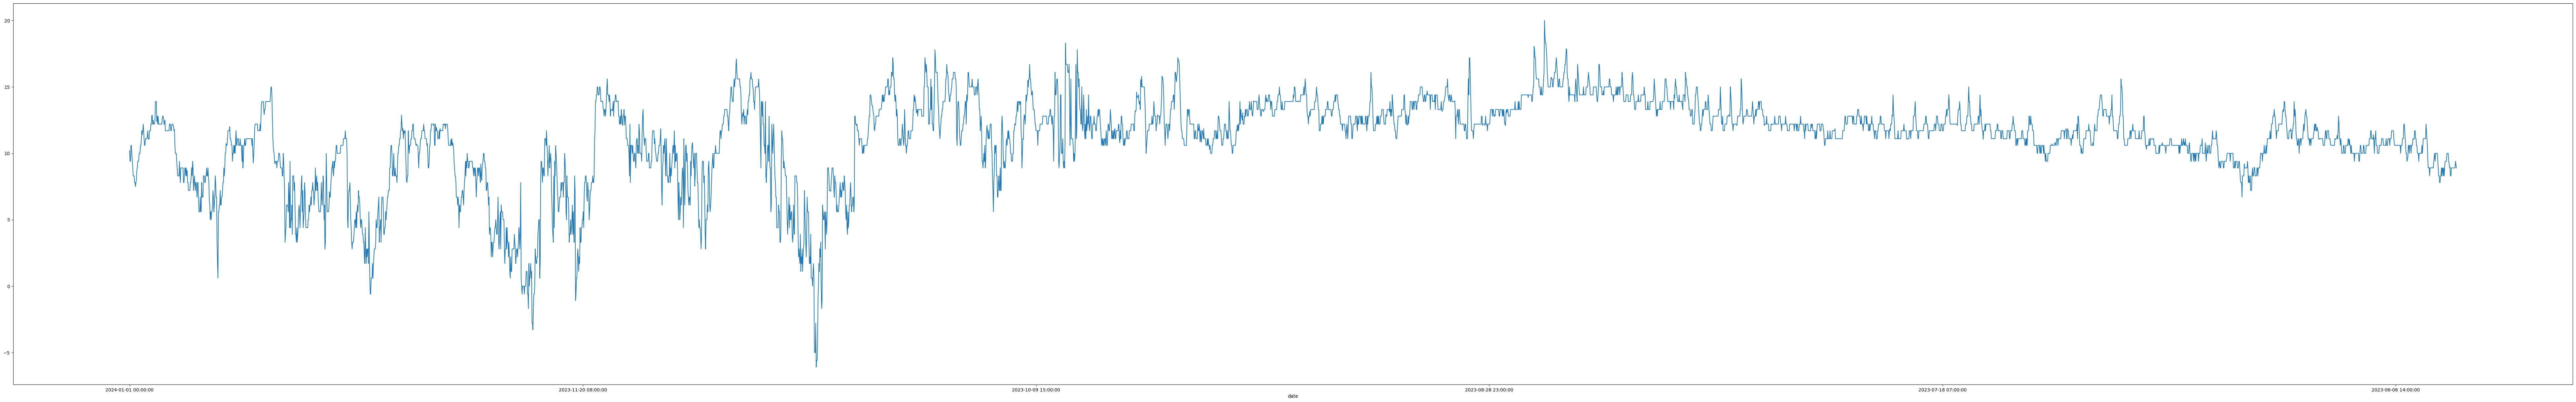

In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 100, 15
df['dewptm'].plot()

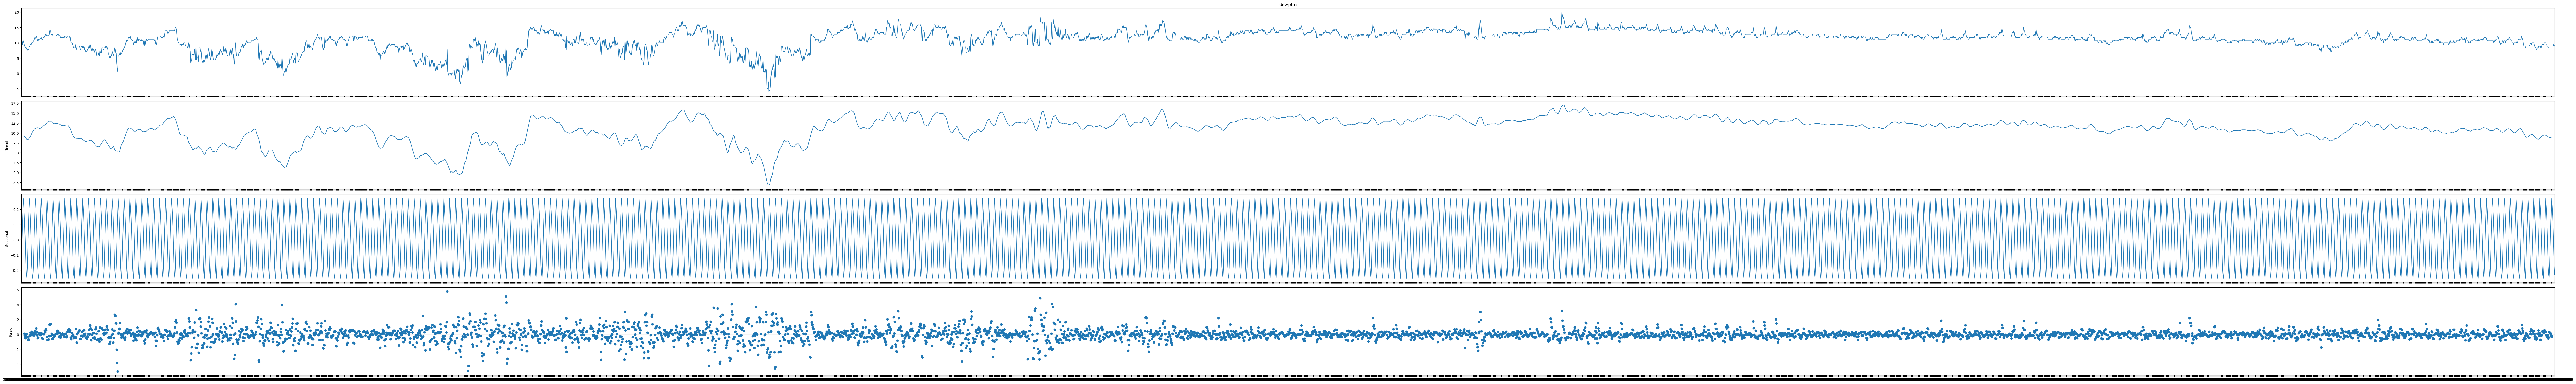

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['dewptm'], model='additive', period=12) 
result.plot()
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller

def adf_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

In [8]:
adf_test(df['dewptm'])

ADF Test Statistic : -4.823615083145261
p-value : 4.90023883512862e-05
#Lags Used : 31
Number of Observations : 5103
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<Figure size 1200x600 with 0 Axes>

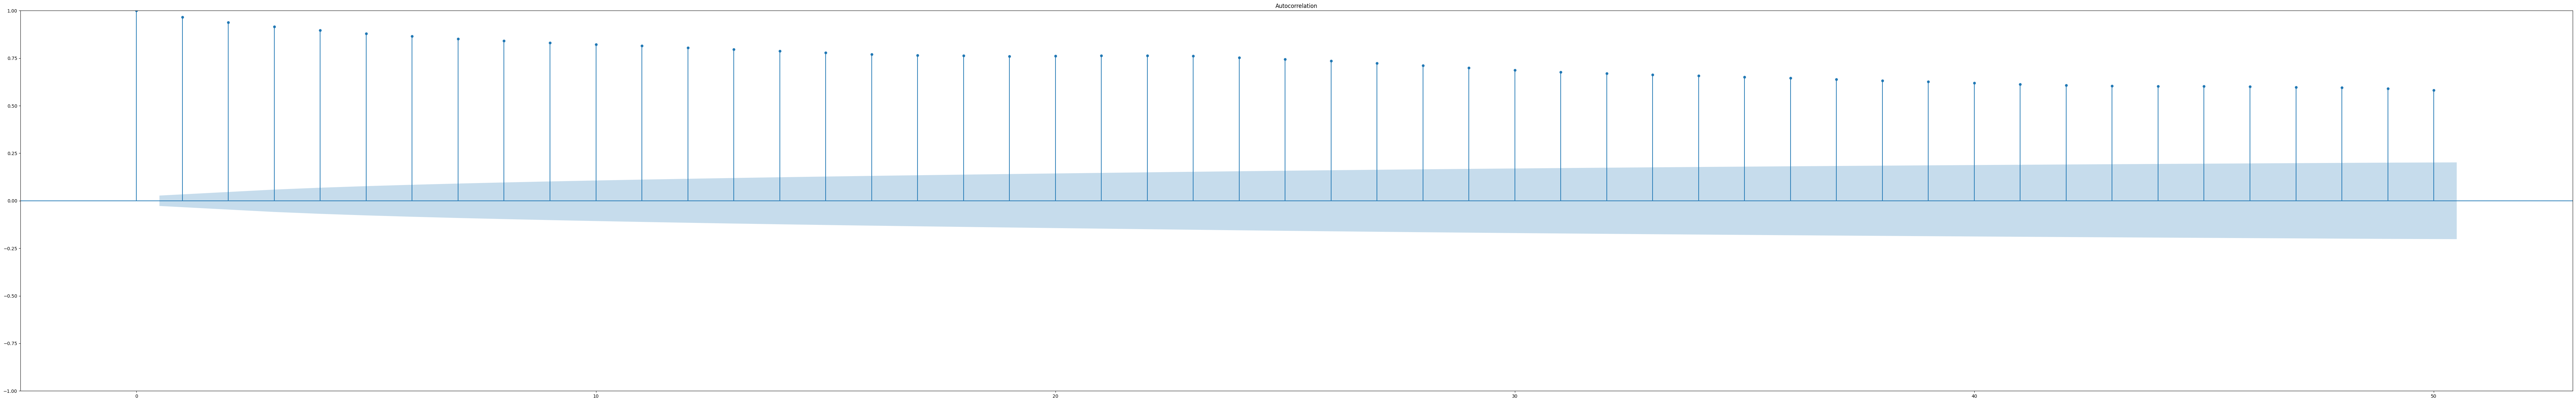

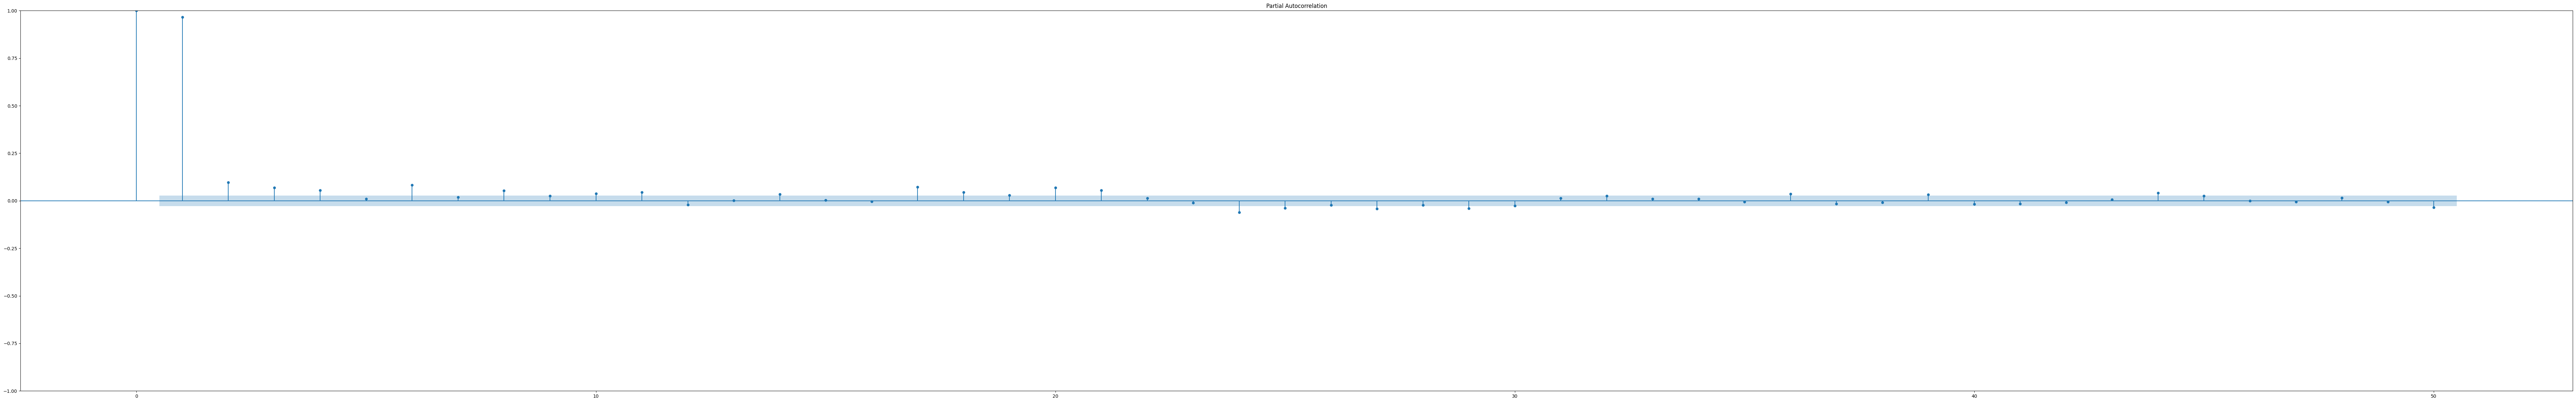

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(df['dewptm'], lags=50) # p = 
plot_pacf(df['dewptm'], lags=50) # q = 
plt.show()

# **ARIMA MODEL**

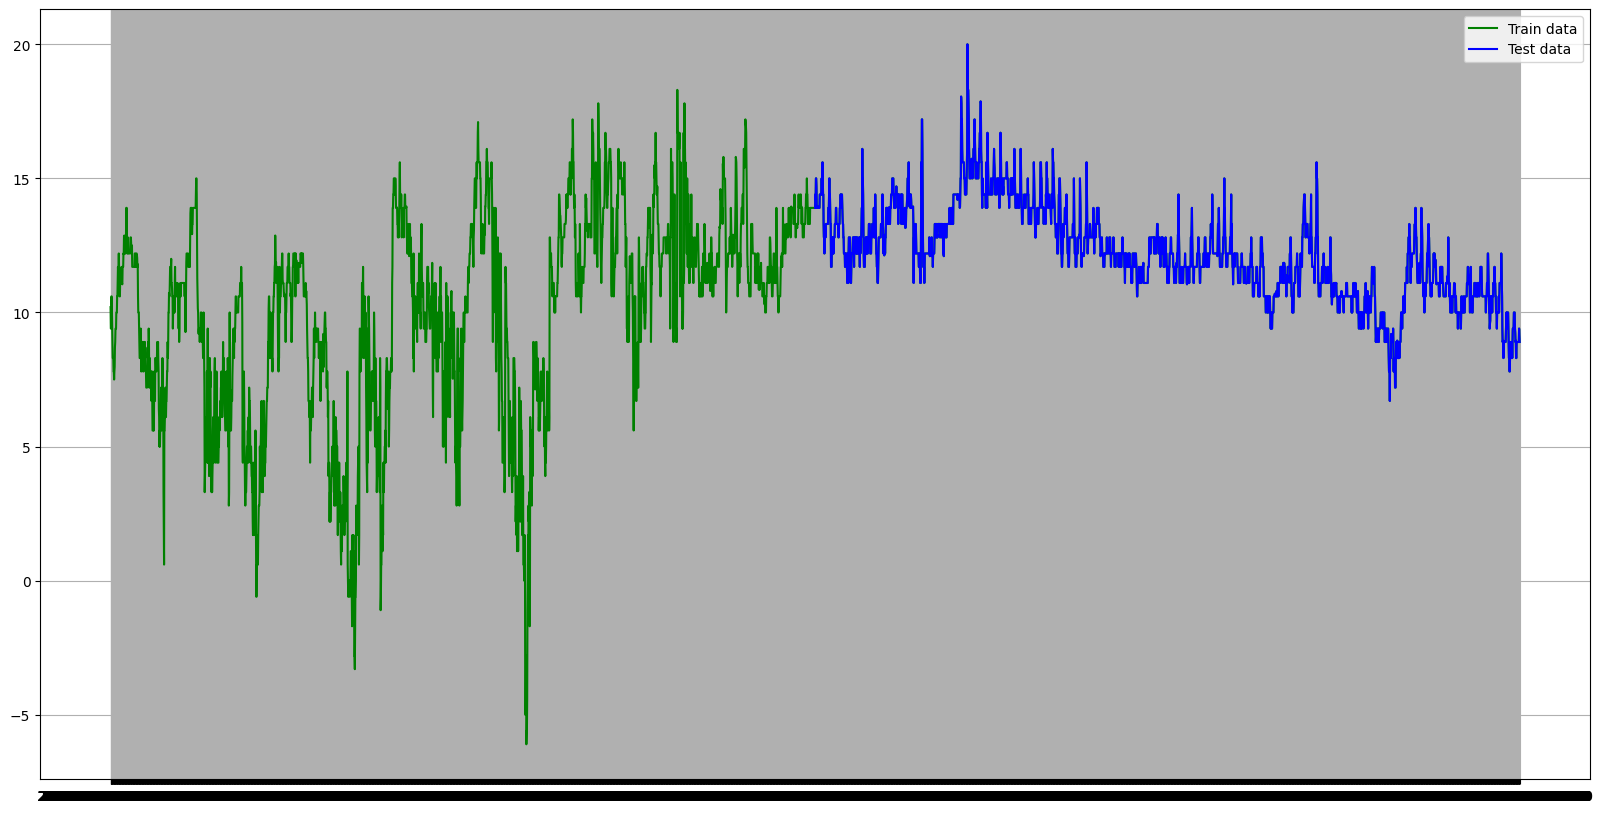

In [10]:
train_data, test_data = df[:int(len(df)*0.5)], df[int(len(df)*0.5):]
plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(df['dewptm'], 'green', label='Train data')
plt.plot(test_data['dewptm'], 'blue', label='Test data')
plt.legend()

In [11]:
'''import itertools
import warnings
warnings.filterwarnings("ignore")
q_arima = range(0, 12)
d_arima = range(0,1)
p_arima = range(0, 12)
AIC_arima = []
ARIMAX_model = []
pdqs = [(x[0], x[1], x[2]) for x in list(itertools.product(p_arima, d_arima, q_arima))]

for pdq in pdqs:
    try:
        mod = ARIMA(train_data['dewptm'],order=pdq)

        results = mod.fit()
        print('ARIMAX{} - AIC:{}'.format(pdq, results.aic), end='\r')
        AIC_arima.append(results.aic)
        ARIMAX_model.append([(1,1,0), pdq])
    except:
            continue
    
print('The smallest AIC is {} for model ARIMAX{}'.format(min(AIC_arima),ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]))
order_a = ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]'''

'import itertools\nimport warnings\nwarnings.filterwarnings("ignore")\nq_arima = range(0, 12)\nd_arima = range(0,1)\np_arima = range(0, 12)\nAIC_arima = []\nARIMAX_model = []\npdqs = [(x[0], x[1], x[2]) for x in list(itertools.product(p_arima, d_arima, q_arima))]\n\nfor pdq in pdqs:\n    try:\n        mod = ARIMA(train_data[\'dewptm\'],order=pdq)\n\n        results = mod.fit()\n        print(\'ARIMAX{} - AIC:{}\'.format(pdq, results.aic), end=\'\r\')\n        AIC_arima.append(results.aic)\n        ARIMAX_model.append([(1,1,0), pdq])\n    except:\n            continue\n    \nprint(\'The smallest AIC is {} for model ARIMAX{}\'.format(min(AIC_arima),ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]))\norder_a = ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]'

In [12]:
#The smallest AIC is 7562.582710913849 for model ARIMAX(5, 0, 11)
order_a = (5, 0, 11)

In [13]:
train, test = train_data['dewptm'], test_data['dewptm']

model = ARIMA(train, order=order_a)
result = model.fit()

forecast_a = result.get_forecast(steps=len(test))
predicted_mean = forecast_a.predicted_mean

mse = mean_squared_error(test, predicted_mean)
rmse = math.sqrt(mse)
print(f'Mean Squared Error: {mse}')

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be i

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 7.388345264821226


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [14]:
print(mse)
print(rmse)

7.388345264821226
2.7181510746868405


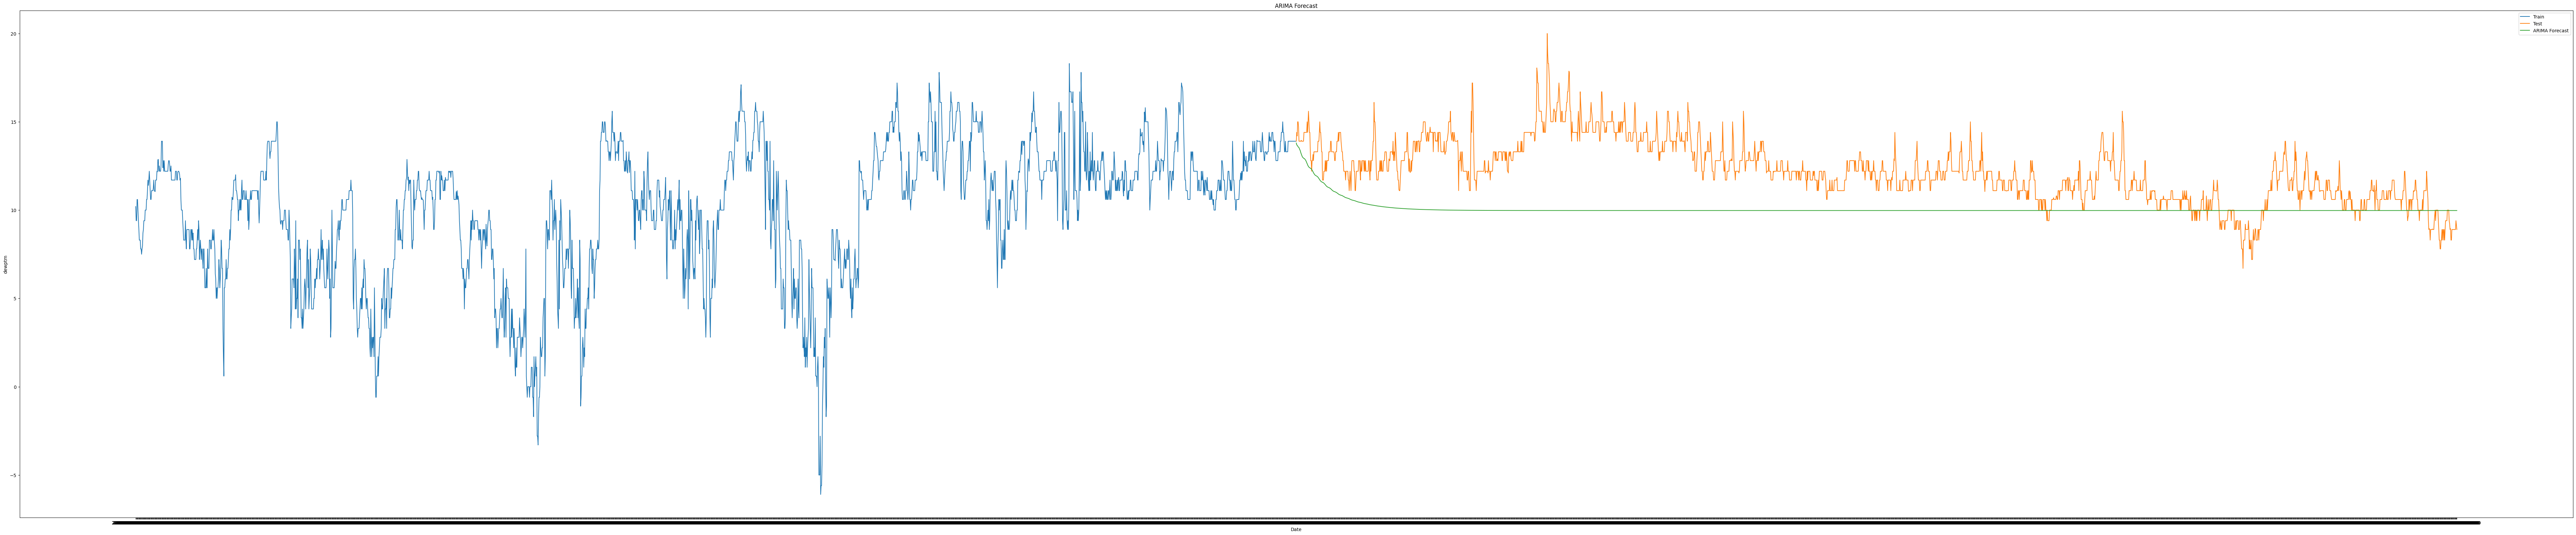

In [15]:
plt.figure(figsize=(100, 20))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predicted_mean, label='ARIMA Forecast')
# plt.fill_between(forecast.conf_int().index,
#                  forecast.conf_int().iloc[:, 0],
#                  forecast.conf_int().iloc[:, 1], color='k', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('dewptm')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

# **QLSTM MODEL**

In [16]:
ARIMA_Result =  pd.DataFrame(columns=['raw', 'predicted','residuals'])
ARIMA_Result['raw'] = test_data['dewptm'].copy()
ARIMA_Result['predicted'] = predicted_mean.to_numpy()
ARIMA_Result['residuals'] = ARIMA_Result['raw'] - ARIMA_Result['predicted']
std_residuals = ARIMA_Result['residuals'].std()
ARIMA_Result['std_residuals'] = ARIMA_Result['residuals'] / std_residuals
ARIMA_Result['nxt_target'] = ARIMA_Result['residuals'].shift(-1)
ARIMA_Result['nxt_target'][len(ARIMA_Result)-1] = ARIMA_Result['nxt_target'][len(ARIMA_Result)-2]
ARIMA_Result

/tmp/ipykernel_1299/2090674876.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ARIMA_Result['nxt_target'][len(ARIMA_Result)-1] = ARIMA_Result['nxt_target'][len(ARIMA_Result)-2]
/tmp/ipykernel_1299/2090674876.py:8: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ARIMA_Result['nxt_target'][len(ARIMA_Result)-1] = ARIMA_Result['nxt_target'][len(ARIMA_Result)-2]


raw  predicted  residuals  std_residuals  nxt_target
date                                                                       
2023-09-16 00:00:00  13.90  13.799099   0.100901       0.059713    0.701630
2023-09-15 23:00:00  14.40  13.698370   0.701630       0.415222    0.538737
2023-09-15 22:00:00  14.20  13.661263   0.538737       0.318823    1.363731
2023-09-15 21:00:00  15.00  13.636269   1.363731       0.807052    1.418519
2023-09-15 20:00:00  15.00  13.581481   1.418519       0.839475    1.139031
...                    ...        ...        ...            ...         ...
2023-06-01 04:00:00   8.90   9.975452  -1.075452      -0.636449   -1.075452
2023-06-01 03:00:00   8.90   9.975452  -1.075452      -0.636449   -0.575452
2023-06-01 02:00:00   9.40   9.975452  -0.575452      -0.340551   -0.825452
2023-06-01 01:00:00   9.15   9.975452  -0.825452      -0.488500   -1.075452
2023-06-01 00:00:00   8.90   9.975452  -1.075452      -0.636449   -1.075452

[2568 rows x 5 columns]

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time

In [18]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:]) 
    data = scaler2.fit_transform(data.iloc[:,:1])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [19]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 2
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 1
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [20]:
size = int(len(ARIMA_Result) * 0.5)

train = ARIMA_Result[['residuals','nxt_target']][:size].copy()
test = ARIMA_Result[['residuals','nxt_target']][size:].copy()

In [21]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [22]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [23]:
class QLSTM(nn.Module):
    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]

            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

class QRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = QLSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [24]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = QRegressionLSTM(num_sensors=1, hidden_units= 6, n_qubits=1)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

weight_shapes = (n_qlayers, n_qubits) = (1, 1)


In [25]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)

count = 0
for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = modelQ(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)}')

[1/5]  LossQ:227.4988485275244
[2/5]  LossQ:118.26432434117305
[3/5]  LossQ:82.27877398292185
[4/5]  LossQ:78.18386360522709
[5/5]  LossQ:75.99103128307615


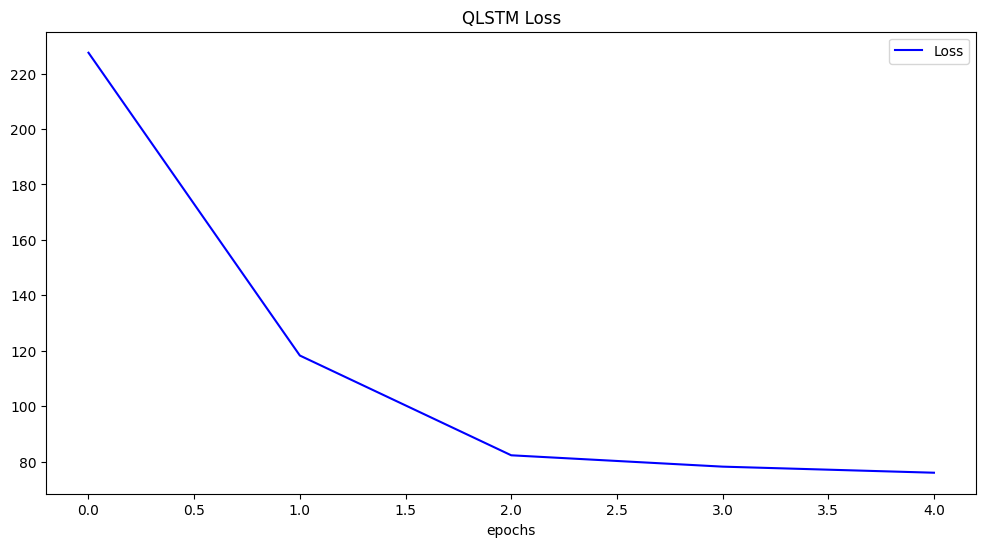

In [26]:
np.savetxt('./SavedModels/Weather/SF/loss/arima_qlstm.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('QLSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [27]:
histQ1 = histQ 

In [28]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)


    return output

In [29]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)

print(pred_y_train)

tensor([-1.2941, -1.2612, -1.2125,  ..., -0.7405, -0.9032, -0.8931],
       grad_fn=<ViewBackward0>)


In [30]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)
pred_y_train

tensor([[-1.2941],
        [-1.2612],
        [-1.2125],
        ...,
        [-0.7405],
        [-0.9032],
        [-0.8931]], grad_fn=<ViewBackward0>)

In [31]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [32]:
np.savetxt('./SavedModels/Weather/SF/train/arima_qlstm.txt',y_train_pred)
np.savetxt('./SavedModels/Weather/SF/test/arima_qlstm.txt',y_test_pred)

Training dataset MSE: 0.5372848779792897 RMSE:0.7329971882478743


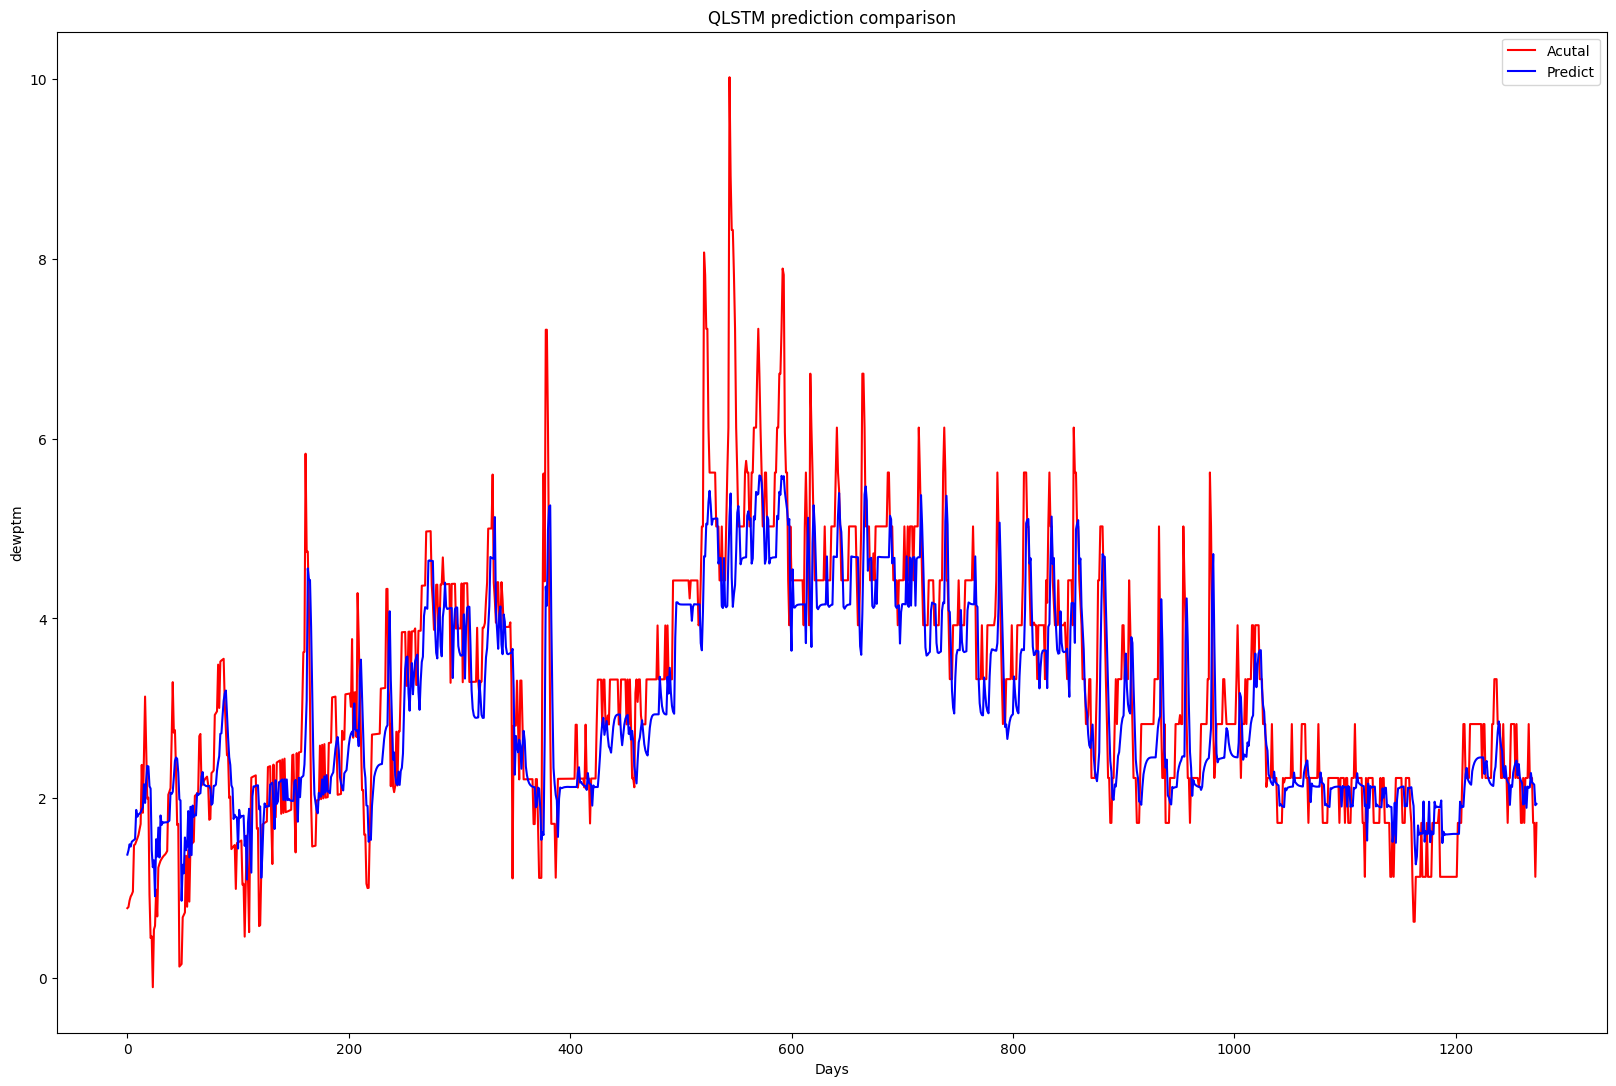

In [33]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('dewptm')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset MSE: {MSE} RMSE:{RMSE}')

Training dataset MSE:0.4072491751731736 RMSE:0.6381607753326536


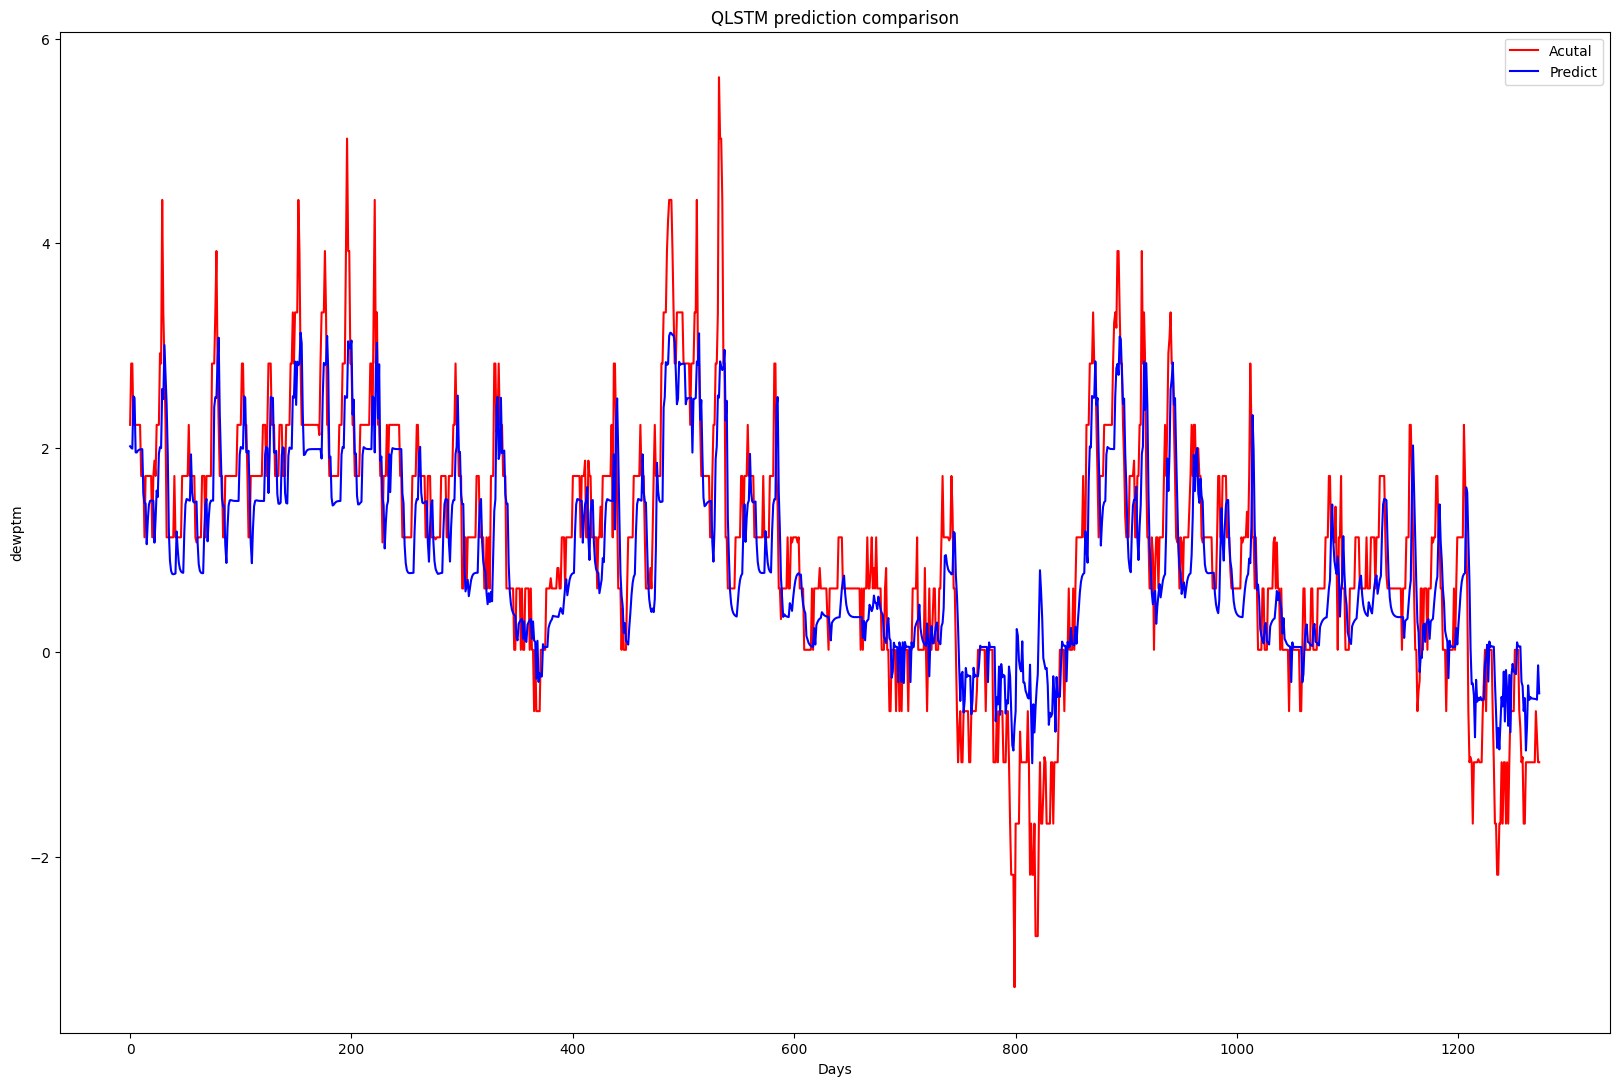

In [34]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('dewptm')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset MSE:{MSE} RMSE:{RMSE}')

In [35]:
final_result_qlstm = ARIMA_Result['predicted'][size+window_size:].values + y_test_pred.squeeze(1)

In [36]:
frq = ARIMA_Result[['predicted','raw']][size+window_size:].copy()
frq['final'] = final_result_qlstm
frq

predicted    raw      final
date                                            
2023-07-24 02:00:00   9.975453  12.20  11.990758
2023-07-24 01:00:00   9.975453  12.20  11.975436
2023-07-24 00:00:00   9.975453  12.80  11.967565
2023-07-23 23:00:00   9.975453  12.80  12.479769
2023-07-23 22:00:00   9.975453  12.20  12.464487
...                        ...    ...        ...
2023-06-01 04:00:00   9.975452   8.90   9.519495
2023-06-01 03:00:00   9.975452   8.90   9.518618
2023-06-01 02:00:00   9.975452   9.40   9.512420
2023-06-01 01:00:00   9.975452   9.15   9.848423
2023-06-01 00:00:00   9.975452   8.90   9.573947

[1274 rows x 3 columns]

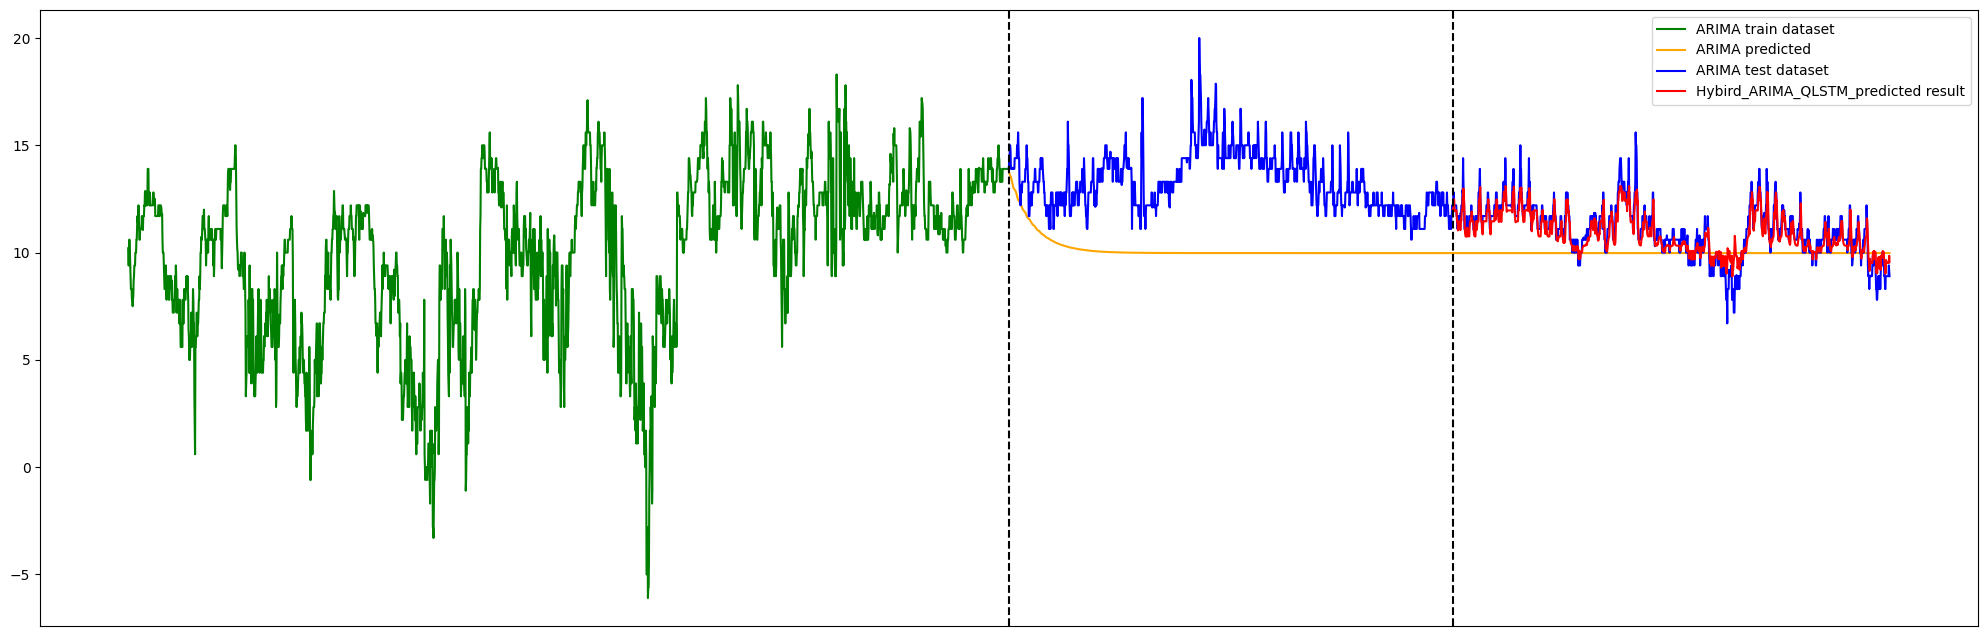

In [37]:
plt.figure(figsize=(25,8))
plt.plot(train_data['dewptm'], label ='ARIMA train dataset', color='green')
plt.plot(ARIMA_Result['predicted'], label ='ARIMA predicted', color='orange')
plt.plot(ARIMA_Result['raw'], label = "ARIMA test dataset", color ='blue')
plt.plot(frq['final'], label = 'Hybird_ARIMA_QLSTM_predicted result', color='red')
plt.axvline(x=len(train_data['dewptm']), c='black', linestyle='--')
plt.axvline(x=len(train_data['dewptm']) + len(ARIMA_Result['predicted']) - len(frq['final']), c='black', linestyle='--')
plt.gca().set_xticks([])
plt.plot()
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(final_result_qlstm,ARIMA_Result['raw'][size+window_size:].values )    
mae = mean_absolute_error(final_result_qlstm, ARIMA_Result['raw'][size+window_size:].values)
rmse = np.sqrt(mse)

print(f'X_test MSE: {mse}')
print(f'X_test MAE: {mae}')
print(f'X_test RMSE: {rmse}')

X_test MSE: 0.32201161875688344
X_test MAE: 0.4313816649951928
X_test RMSE: 0.5674606759563904


In [39]:
torch.save(modelQ.state_dict(),'./SavedModels/Weather/SF/model/arima_QLSTM_sd')

# **LSTM MODEL**

In [40]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [41]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = ShallowRegressionLSTM(num_sensors=1, hidden_units=6)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

In [42]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)

count = 0
for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = modelQ(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)} ')

[1/5]  LossQ:124.94578043807996 
[2/5]  LossQ:80.380258787598 
[3/5]  LossQ:72.04307399770732 
[4/5]  LossQ:65.96120258480369 
[5/5]  LossQ:62.4582502496778 


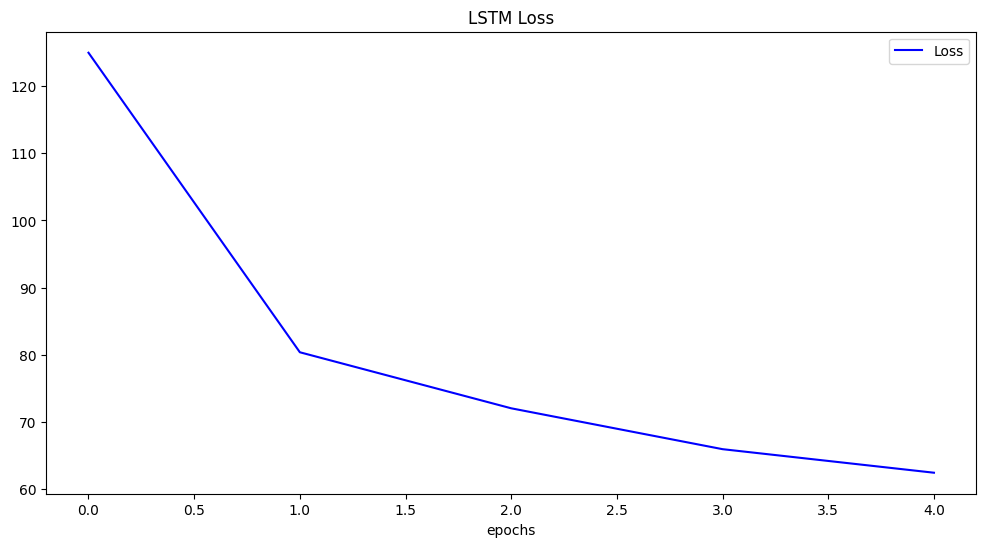

In [43]:
np.savetxt('./SavedModels/Weather/SF/loss/arima_lstm.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('LSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [44]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)

In [45]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [46]:
np.savetxt('./SavedModels/Weather/SF/train/arima_lstm.txt',y_train_pred)
np.savetxt('./SavedModels/Weather/SF/test/arima_lstm.txt',y_test_pred)

Training dataset MSE: 0.7089864893555767 RMSE:0.8420133546183082


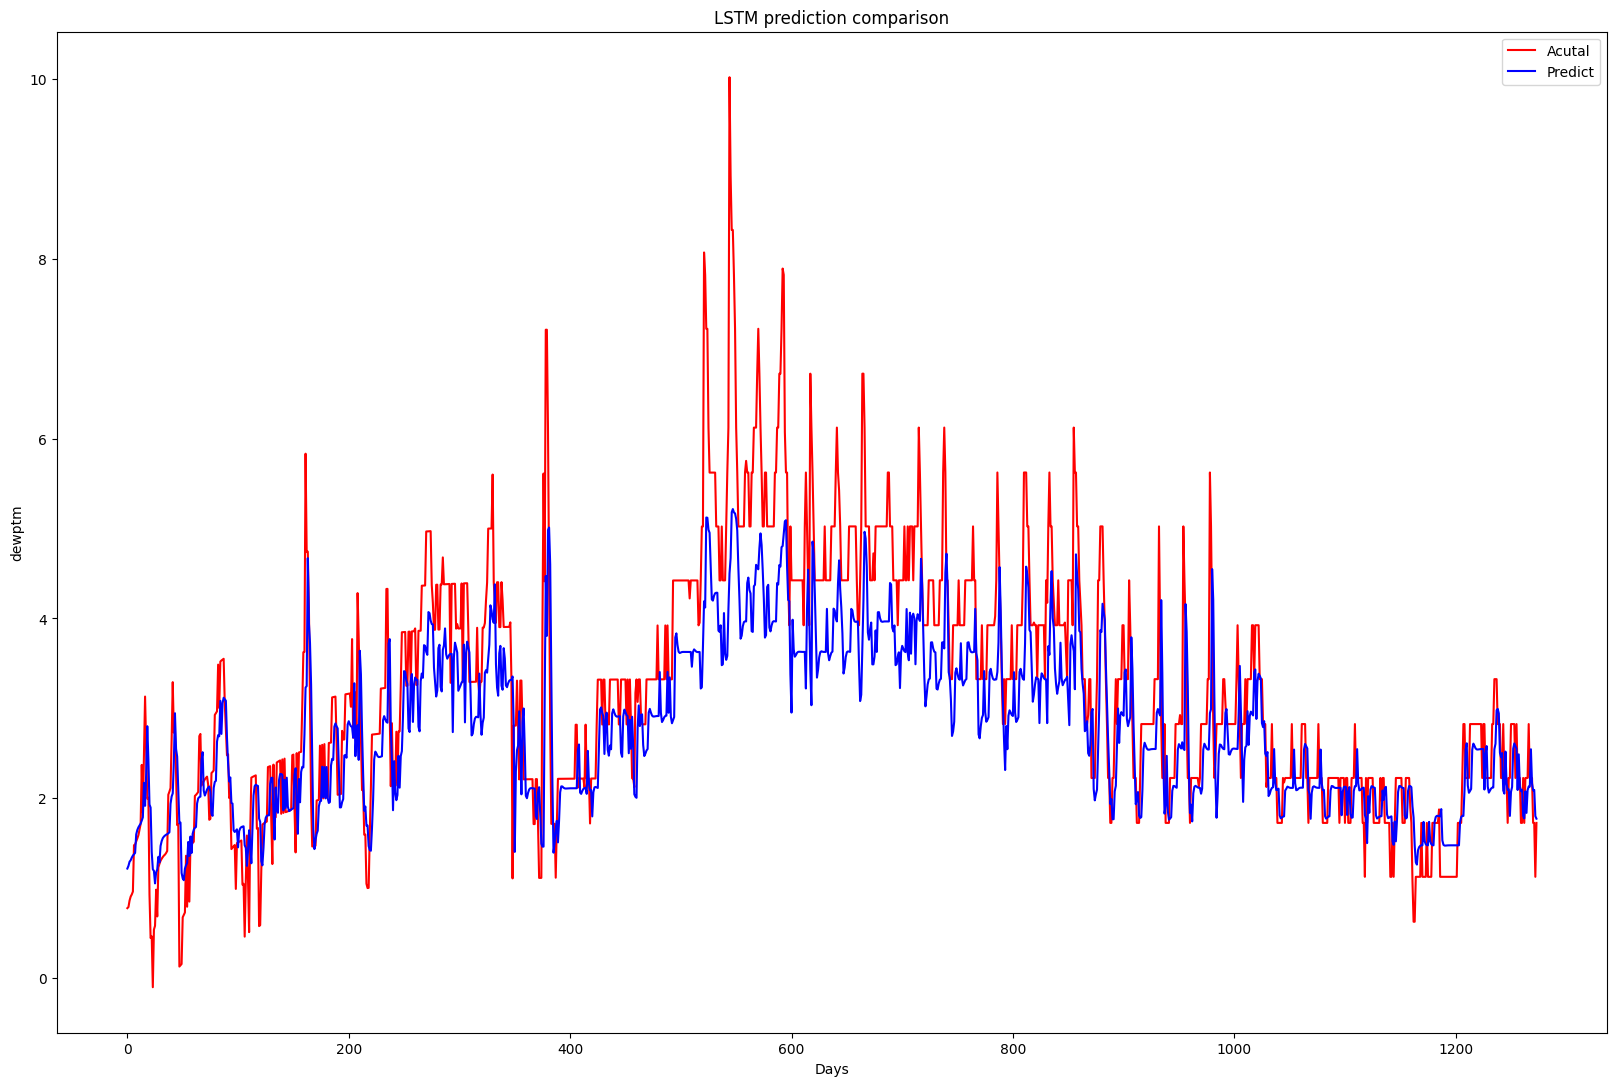

In [47]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('LSTM prediction comparison')
plt.ylabel('dewptm')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset MSE: {MSE} RMSE:{RMSE}')

Training dataset RMSE:0.7076193583025416


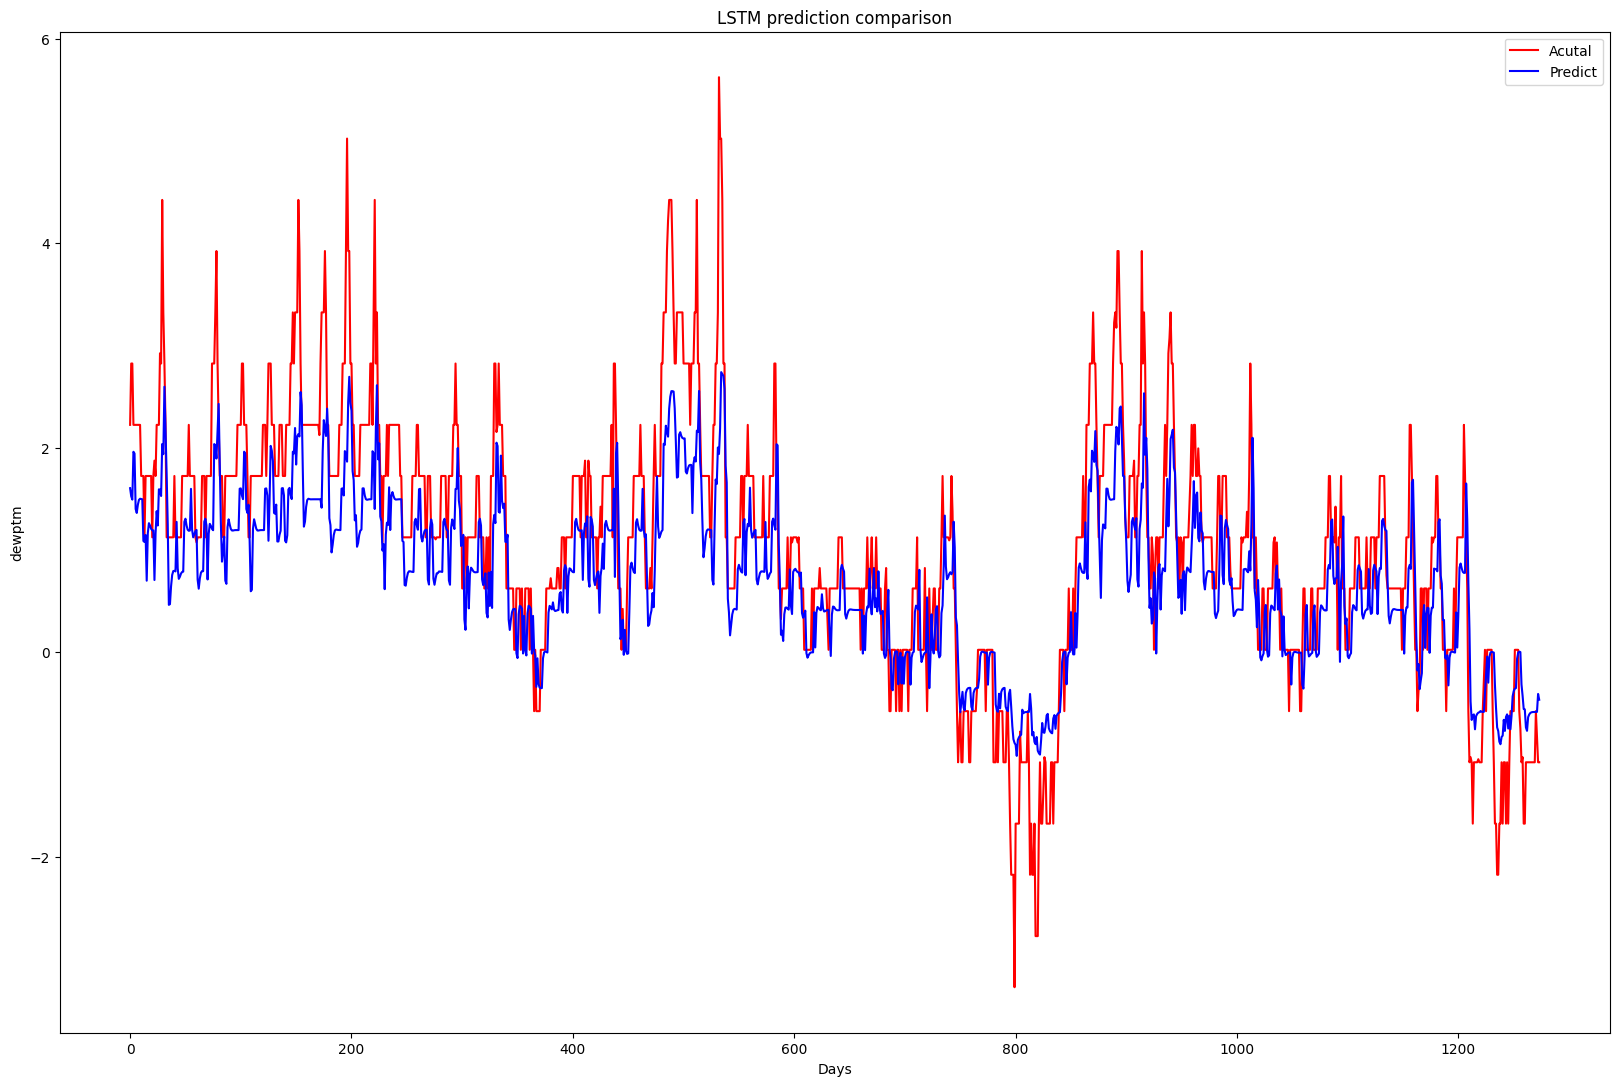

In [48]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('LSTM prediction comparison')
plt.ylabel('dewptm')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [49]:
final_result= ARIMA_Result['predicted'][size+window_size:].values + y_test_pred.squeeze(1)

In [50]:
fr = ARIMA_Result[['predicted','raw']][size+window_size:].copy()
fr['final'] = final_result
fr

predicted    raw      final
date                                            
2023-07-24 02:00:00   9.975453  12.20  11.580872
2023-07-24 01:00:00   9.975453  12.20  11.501205
2023-07-24 00:00:00   9.975453  12.80  11.468870
2023-07-23 23:00:00   9.975453  12.80  11.936834
2023-07-23 22:00:00   9.975453  12.20  11.919696
...                        ...    ...        ...
2023-06-01 04:00:00   9.975452   8.90   9.392339
2023-06-01 03:00:00   9.975452   8.90   9.392465
2023-06-01 02:00:00   9.975452   9.40   9.392583
2023-06-01 01:00:00   9.975452   9.15   9.568206
2023-06-01 00:00:00   9.975452   8.90   9.511691

[1274 rows x 3 columns]

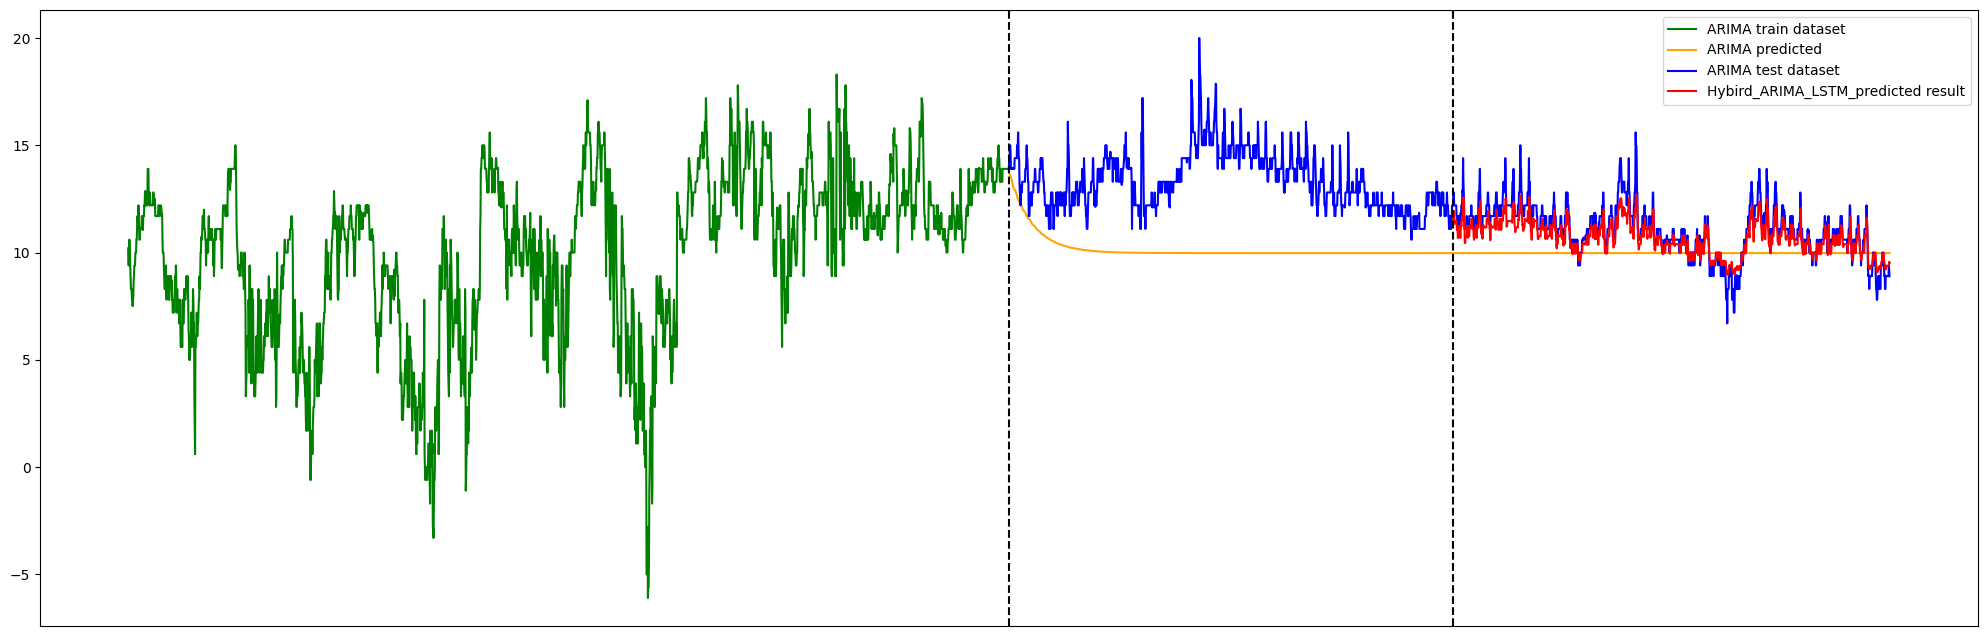

In [51]:
plt.figure(figsize=(25,8))
plt.plot(train_data['dewptm'], label ='ARIMA train dataset', color='green')
plt.plot(ARIMA_Result['predicted'], label ='ARIMA predicted', color='orange')
plt.plot(ARIMA_Result['raw'], label = "ARIMA test dataset", color ='blue')
plt.plot(fr['final'], label = 'Hybird_ARIMA_LSTM_predicted result', color='red')
plt.axvline(x=len(train_data['dewptm']), c='black', linestyle='--')
plt.axvline(x=len(train_data['dewptm']) + len(ARIMA_Result['predicted']) - len(frq['final']), c='black', linestyle='--')
plt.gca().set_xticks([])
plt.plot()
plt.legend()
plt.show()

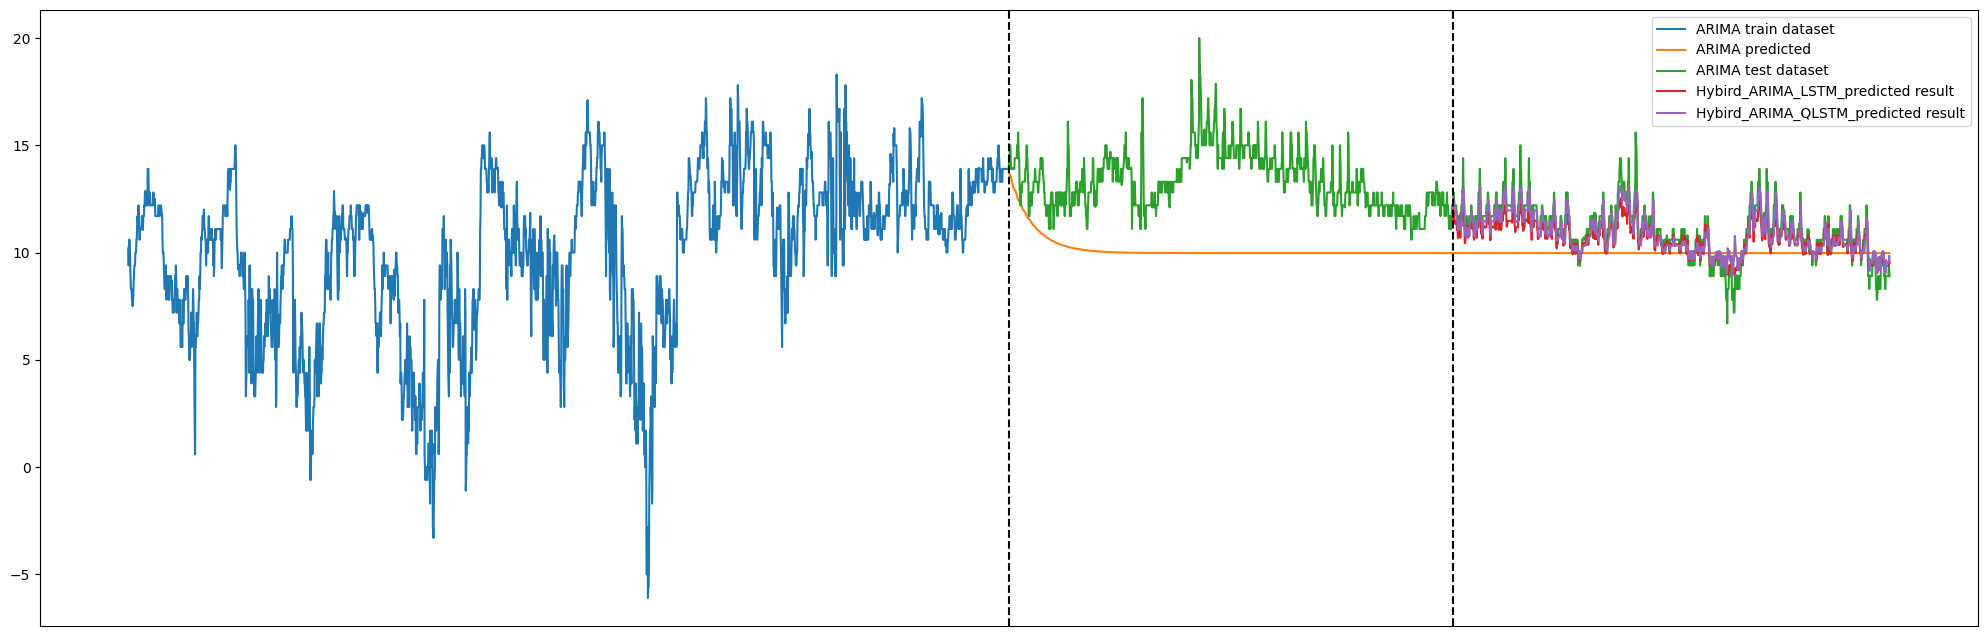

In [52]:
plt.figure(figsize=(25,8))
plt.plot(train_data['dewptm'], label ='ARIMA train dataset')
plt.plot(ARIMA_Result['predicted'], label ='ARIMA predicted')
plt.plot(ARIMA_Result['raw'], label = "ARIMA test dataset")
plt.plot(fr['final'], label = 'Hybird_ARIMA_LSTM_predicted result')
plt.plot(frq['final'], label = 'Hybird_ARIMA_QLSTM_predicted result')
plt.axvline(x=len(train_data['dewptm']), c='black', linestyle='--')
plt.axvline(x=len(train_data['dewptm']) + len(ARIMA_Result['predicted']) - len(frq['final']), c='black', linestyle='--')
plt.gca().set_xticks([])
plt.plot()
plt.legend()
plt.show()

In [53]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(final_result,ARIMA_Result['raw'][size+window_size:].values )    
mae = mean_absolute_error(final_result, ARIMA_Result['raw'][size+window_size:].values)
rmse = np.sqrt(mse)

print(f'X_test MSE: {mse}')
print(f'X_test MAE: {mae}')
print(f'X_test RMSE: {rmse}')

X_test MSE: 0.4324834617135316
X_test MAE: 0.5158554049257952
X_test RMSE: 0.657634747951727


In [54]:
torch.save(modelQ,'./SavedModels/Weather/SF/model/arima_lstm')

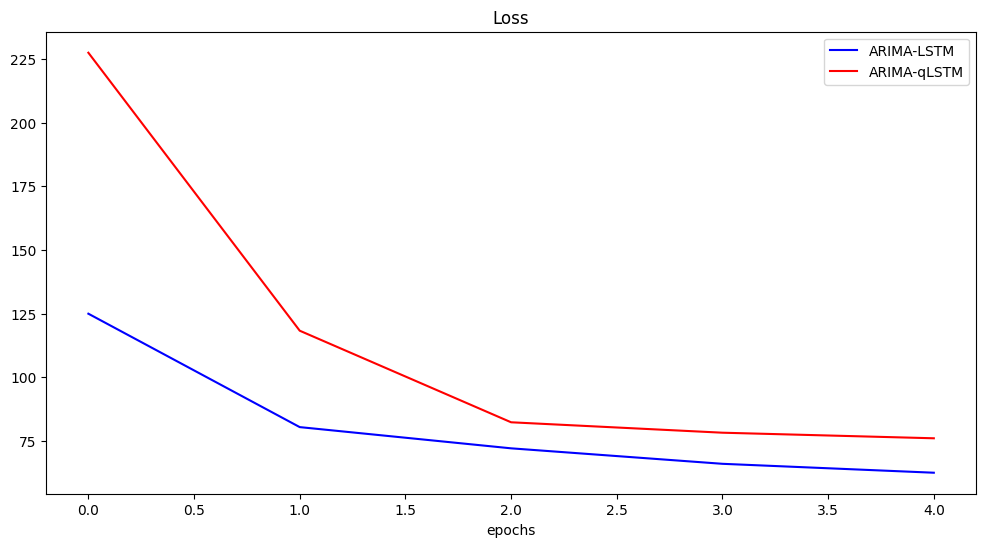

In [55]:
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'ARIMA-LSTM')
plt.plot(histQ1, color='red', label='ARIMA-qLSTM')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')